In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

pro = ts.pro_api('6a556bff9d65d2106c76bbdaef29f4e690a049cc4d58266849c14d20')

In [4]:
'''
深度学习模型暂时无法处理黑天鹅,2021/2/8 600754 实际涨停板，预测是下跌的行情，该日股票套牢，之前2周盈利一半损失。
准备做回测，复盘完全按照预测操作，看到2021/2/8 盈利与个人操作的差异。
深度学习肯定是可以用在股票市场的，比如针对某只股票的新闻情感分析等。

'''
#now = datetime.now()
#预测开始日期与训练结束日期重叠，目的训练只要取一次数据
#预测第二日的最高价，预测数据日期需要向后偏移一天；为了减少取数次数，预测时候删除第一日，训练数据删除最后一日

#预测数据开始、结束日期
#dt4 = (datetime.datetime.now() + datetime.timedelta(days=-1)) #.strftime("%Y%m%d")
_tscode='600754.SH'
#_tscode='600676.SH'
#_tscode='600436.SH' 

sb = pro.stock_basic(ts_code=_tscode)
_title = sb.loc[0]['symbol']+' '+sb.loc[0]['name']
print(_title)
print('---------------------------')

#是否包含融资融券数据，上交所基本在早上8.20之前公布前一个交易日数据；深交所在8.50左右公布
is_rzrq = True
#是否包含沪港通余额
is_hk = True

dt4 = datetime.datetime.now() #.strftime("%Y%m%d")
dt3 = dt4+datetime.timedelta(days=-26)
print(dt3.strftime("%Y-%m-%d"))
print(dt4.strftime("%Y-%m-%d"))

#训练、测试数据开始日期，结束日期
dt1 =  datetime.datetime.now()+ datetime.timedelta(days=-366)
dt2 = (dt4 + datetime.timedelta(days=-20)) #.strftime("%Y%m%d")
#print("----------")
#print(dt1.strftime("%Y-%m-%d"))
#print(dt2.strftime("%Y-%m-%d"))

#日线行情
da = pro.daily(ts_code=_tscode, start_date=dt1.strftime("%Y%m%d"), end_date=dt2.strftime("%Y%m%d"))
#每日指标
db = pro.daily_basic(ts_code=_tscode,start_date=dt1.strftime("%Y%m%d"),end_date=dt2.strftime("%Y%m%d"))

sub_db = db.loc[:,['trade_date','turnover_rate','volume_ratio']]
df1 = pd.merge(da,sub_db)

#融资融券
if is_rzrq:
    md = pro.margin_detail(ts_code=_tscode, start_date=dt1.strftime("%Y%m%d"), end_date=dt2.strftime("%Y%m%d"))
    sub_md = md.loc[:,['trade_date','rzye','rqye']]
    sub_md['rzye'] = sub_md['rzye'].div(10000)
    sub_md['rqye'] = sub_md['rqye'].div(10000)
    df1 = pd.merge(df1,sub_md)
#print(sub_md.head(5))

#港股通余额
if is_hk:
    hh = pro.hk_hold(ts_code=_tscode, start_date=dt1.strftime("%Y%m%d"), end_date=dt2.strftime("%Y%m%d"))
    hh['hk_vol'] = hh['vol'].div(10000)
    sub_hh = hh.loc[:,['trade_date','hk_vol']]
    df1 = pd.merge(df1,sub_hh)
    #print(sub_hh.head(5))


X = df1[1:].drop(['ts_code','trade_date'],axis=1)
#print(X.columns)
#训练day+1 的最高价
y = df1[:-1]['high']
#print(X)

#训练day+1 的最低价
V = df1[1:].drop(['ts_code','trade_date'],axis=1)
z = df1[:-1]['low']

#有字段是NAN值 ，需要替换
X.fillna(0,inplace=True)
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

#训练最低价
V_train, V_test, z_train,z_test = train_test_split(V, z, test_size=0.2,shuffle=True)

600754 锦江酒店
---------------------------
2021-02-03
2021-03-01


elaspe: 0.031935; train_score: 0.991325; cv_score: 0.988550


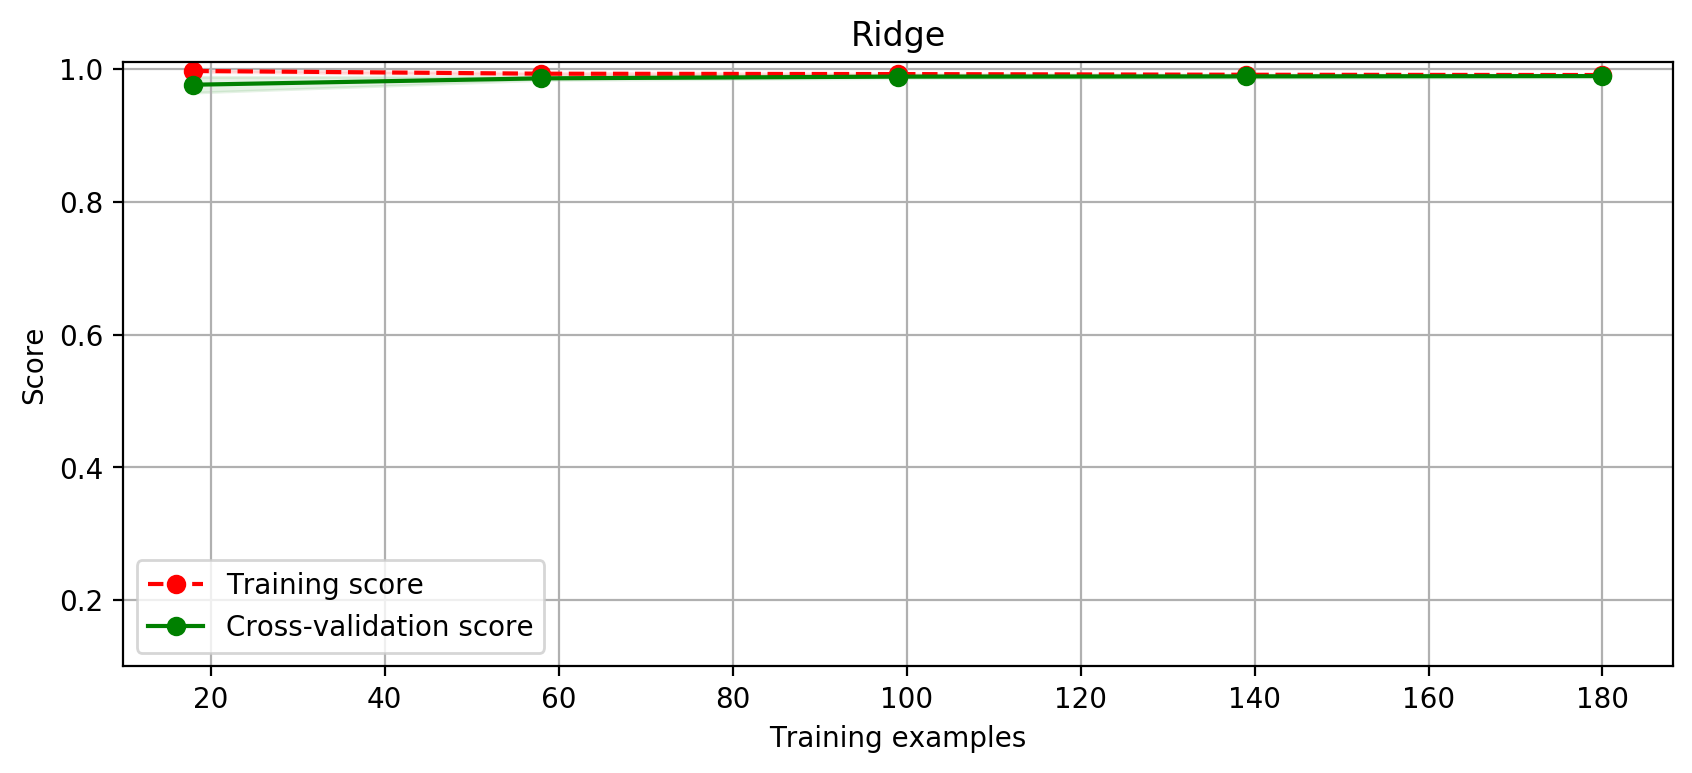

elaspe: 0.845575; train_score: 0.992980; cv_score: 0.994832


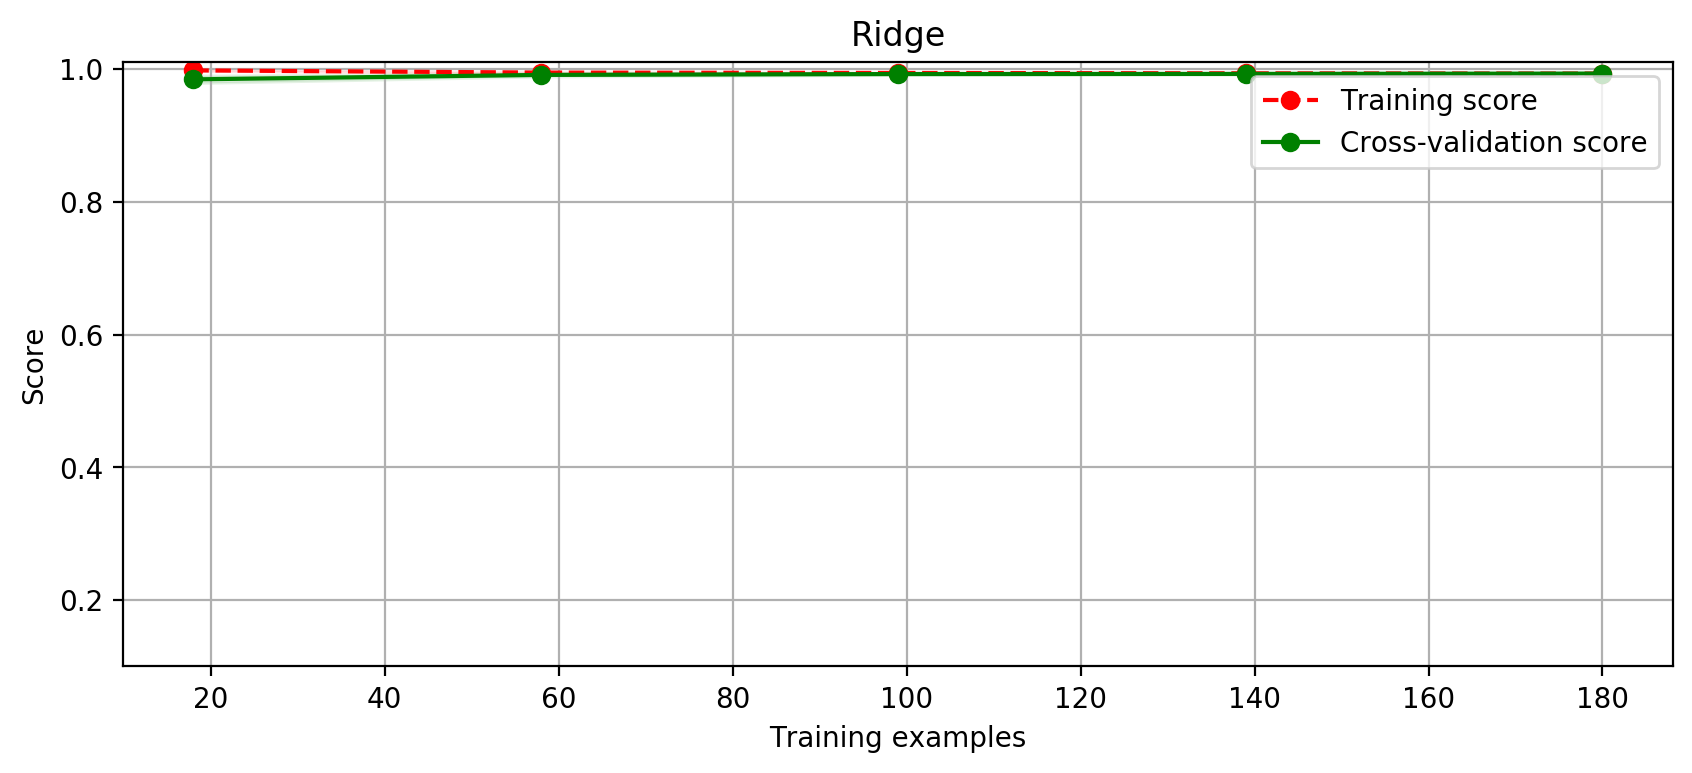

In [5]:
import time
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from common.utils import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import svm

#model = LinearRegression()
model = Ridge (alpha = .5)
start = time.perf_counter()
model.fit(X_train, y_train)


train_score = model.score(X_train, y_train)
cv_score = model.score(X_test, y_test)
print('elaspe: {0:0.6f}; train_score: {1:0.6f}; cv_score: {2:0.6f}'.format(time.perf_counter()-start, train_score, cv_score))

plt.figure(figsize=(10,4),dpi=200)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(plt, Ridge(), "Ridge", X, y, ylim=(0.1, 1.01), cv=cv)
#参数不能过多，过多会过拟合 高方差，含义是现有数据拟合很好，新数据拟合误差大
plt.show()


#model = LinearRegression()
z_model = Ridge (alpha = .5)
z_start = time.perf_counter()
z_model.fit(V_train, z_train)


z_train_score = z_model.score(V_train, z_train)
z_cv_score = z_model.score(V_test, z_test)
print('elaspe: {0:0.6f}; train_score: {1:0.6f}; cv_score: {2:0.6f}'.format(time.perf_counter()-start, z_train_score, z_cv_score))

plt.figure(figsize=(10,4),dpi=200)
z_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(plt, Ridge(), "Ridge", V, z, ylim=(0.1, 1.01), cv=z_cv)
#参数不能过多，过多会过拟合 高方差，含义是现有数据拟合很好，新数据拟合误差大
plt.show()

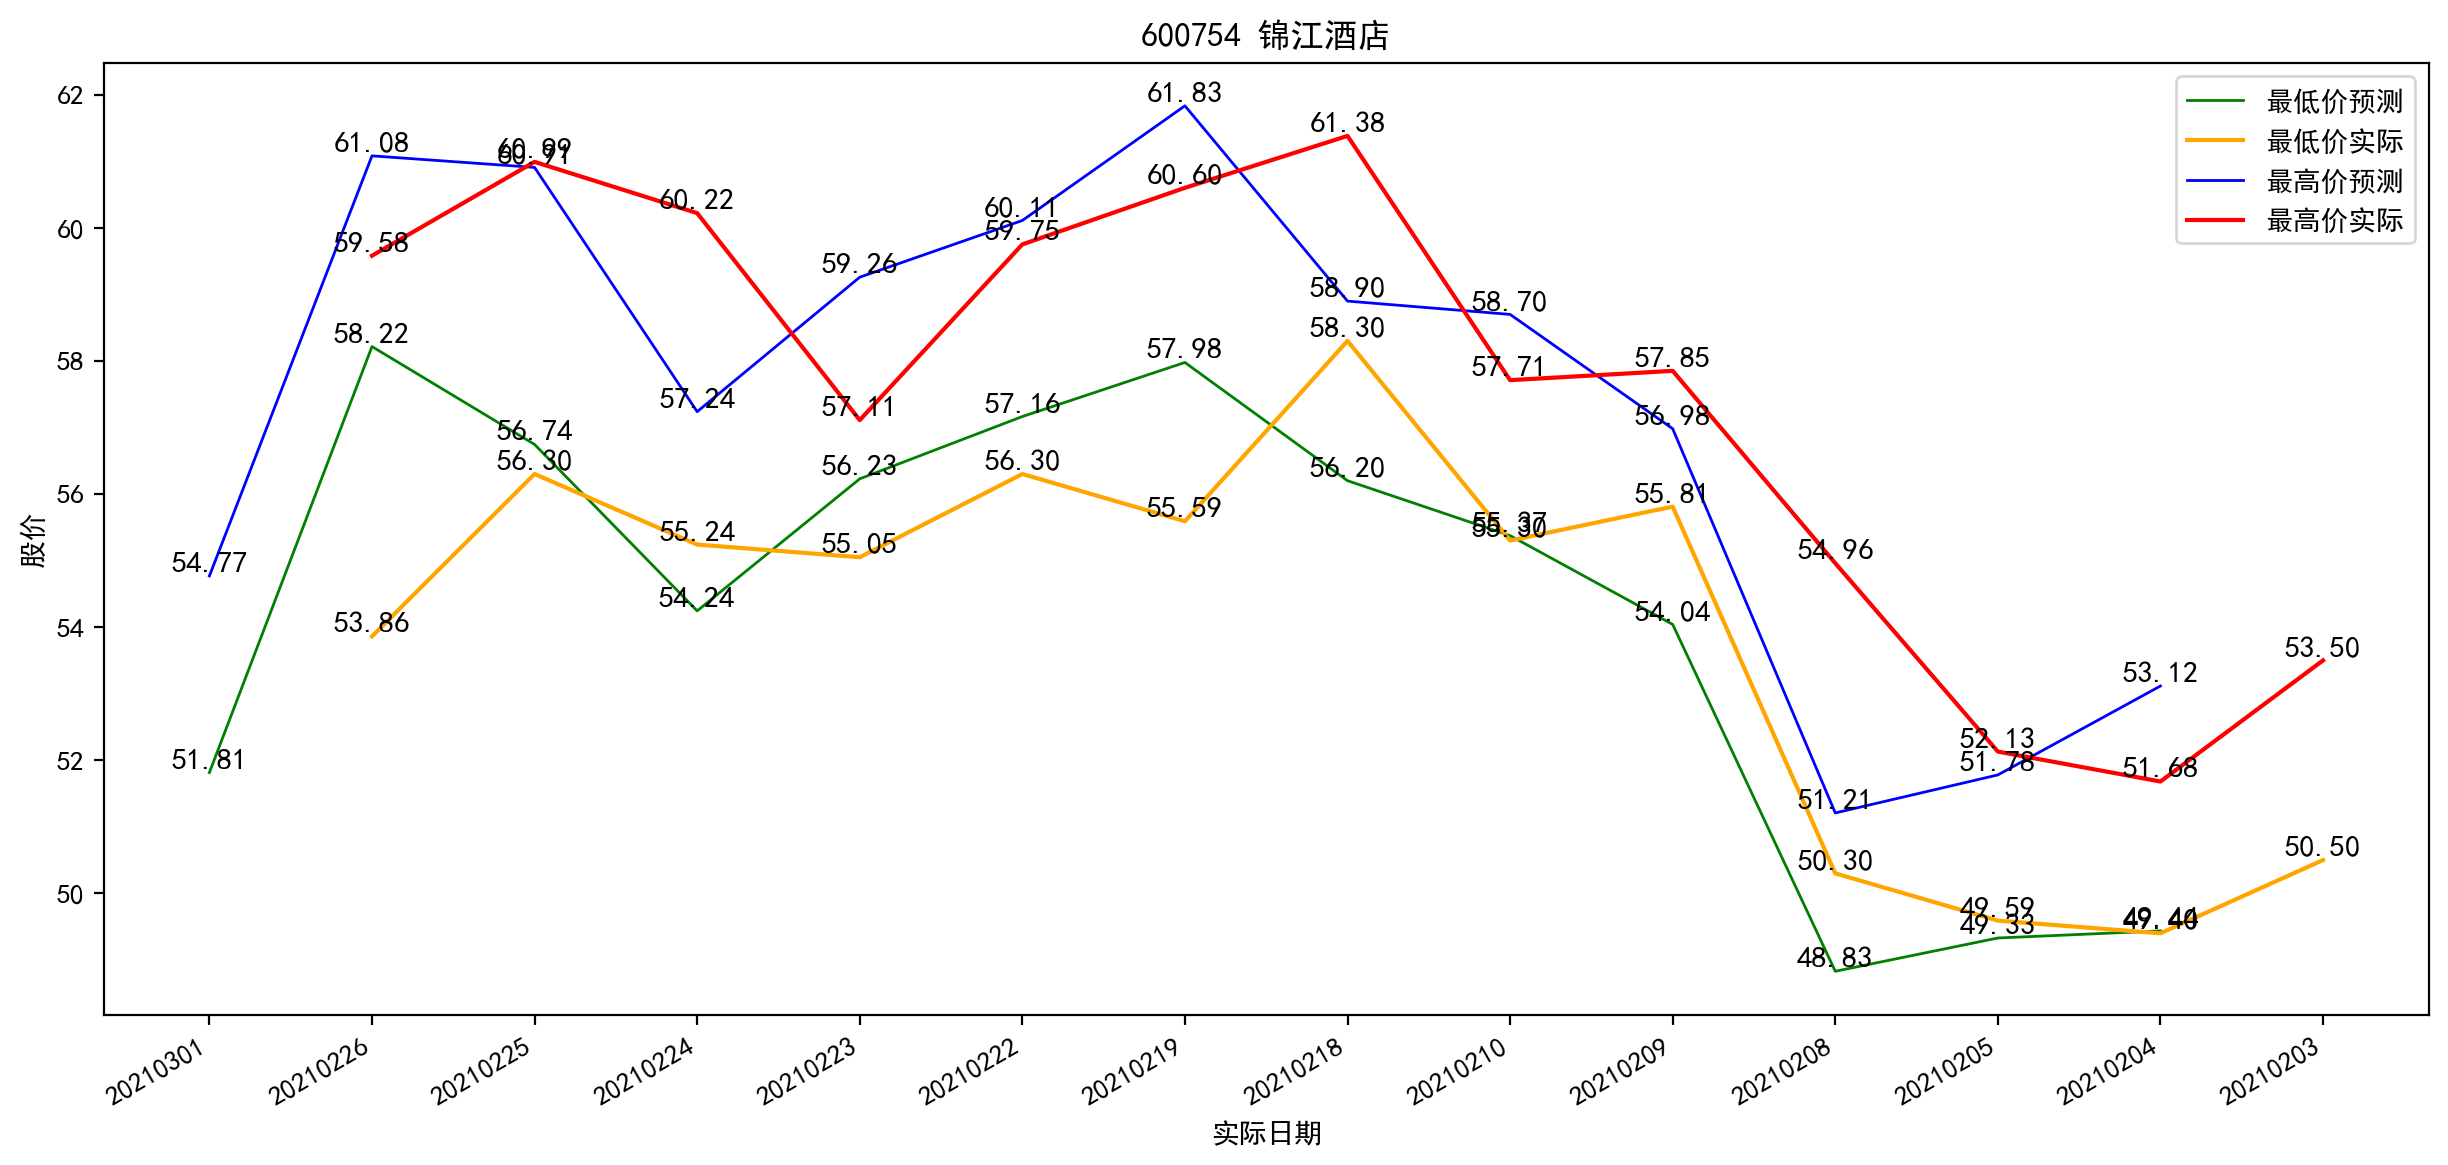

In [6]:
import matplotlib.dates as mdate

#预测数据 
p_da = pro.daily(ts_code=_tscode, start_date=dt3.strftime("%Y%m%d"), end_date=dt4.strftime("%Y%m%d"))

p_db = pro.daily_basic(ts_code=_tscode,start_date=dt3.strftime("%Y%m%d"),end_date=dt4.strftime("%Y%m%d"))
sub_p_db= p_db.loc[:,['trade_date','turnover_rate','volume_ratio']]
df2=pd.merge(p_da,sub_p_db)
#print(df2.head(5))

if is_rzrq:
    #融资融券
    md = pro.margin_detail(ts_code=_tscode, start_date=dt3.strftime("%Y%m%d"), end_date=dt4.strftime("%Y%m%d"))
    sub_md = md.loc[:,['trade_date','rzye','rqye']]
    sub_md['rzye'] = sub_md['rzye'].div(10000)
    sub_md['rqye'] = sub_md['rqye'].div(10000)
    df2 = pd.merge(df2,sub_md)
    #print(sub_md.head(5))

#港股通余额
if is_hk:
    hh = pro.hk_hold(ts_code=_tscode, start_date=dt3.strftime("%Y%m%d"), end_date=dt4.strftime("%Y%m%d"))
    hh['hk_vol'] = hh['vol'].div(10000)
    sub_hh = hh.loc[:,['trade_date','hk_vol']]
    df2 = pd.merge(df2,sub_hh)
    #print(sub_hh.head(5))


#预测的是 daily + 1日期的数据
#删除日期列，日期列跨年引起预测数据巨大差异
df3 = df2[:].drop(['ts_code','trade_date'],axis=1)
#df3 = df2[:].drop(['ts_code'],axis=1)
df3.fillna(0,inplace=True)
#print(df3.head(5))
#print(df3.shape)

##############最高价显示##############
X_train_1 = model.predict(df3)
#print('预测最高价：')
#print(X_train_1)
#print()
Z_train_1 = z_model.predict(df3)
#print('预测最低价：')
#print(Z_train_1)

#图形显示
plt.rcParams['font.family']=['sans-serif']
plt.rcParams['font.sans-serif']=['SimHei'] 

fig, ax = plt.subplots(figsize=(15,7),dpi=200)

y1 = X_train_1
y2 = p_da[:]['high']

#获取预测用日线行情当前日期
str_dt = p_da.iloc[0]['trade_date']
end_dt = datetime.datetime.strptime(str_dt, '%Y%m%d')+datetime.timedelta(days=+30)
#print(end_dt)

str_dt =  p_da.iloc[(p_da.iloc[:,0].size)-1]['trade_date']
start_dt = datetime.datetime.strptime(str_dt, '%Y%m%d')
#print(start_dt)

#x1 预测日期 ,x2 实际日期
df_c = pro.query('trade_cal', start_date=start_dt.strftime("%Y%m%d"),end_date=end_dt.strftime("%Y%m%d"),is_open=1)
#dataframe 倒排序 .iloc[::-1]
x1 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['high'].size -1 ):-1]['cal_date'].values
#print(x1)
x2 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['high'].size):]['cal_date'].values
#print(x2)


y3 = Z_train_1
y4 = p_da[:]['low']
x3 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['low'].size -1 ):-1]['cal_date'].values
#print(x1)
x4 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['low'].size):]['cal_date'].values
#print(x2)

plt.plot(x3,y3, color='green', linewidth=1, label='最低价预测')
for a,b in zip(x3,y3):
    plt.text(a,b,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)

plt.plot(x4,y4, color='orange', linewidth=1.5,label='最低价实际')
for a,b in zip(x4,y4):
    plt.text(a,b,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)

plt.plot(x1,y1, color='blue', linewidth=1, label='最高价预测')
for a,b in zip(x1,y1):
    plt.text(a,b,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)

plt.plot(x2,y2, color='red', linewidth=1.5,label='最高价实际')
for a,b in zip(x2,y2):
    plt.text(a,b,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)
    
plt.xlabel('实际日期')
plt.ylabel('股价')

# Add a table at the bottom of the axes
'''
_cell = np.vstack((Z_train_1,p_da[:]['high'].values,X_train_1,p_da[:]['low'].values))
print(_cell.shape)
the_table = plt.table(cellText=_cell,rowLabels=['最高价预测','最高价实际','最低价预测','最低价实际'],
                      colLabels=x1,loc='bottom')
'''

plt.legend() 
plt.gcf().autofmt_xdate()
plt.title(_title)
plt.show()

In [120]:
#平均计算误差的绝对值
#当日挂单最高价 =  预测最高价 - 平均误差
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.metrics import mean_absolute_error # 平方绝对误差
#print(df3[:-1]['high'])
#print(X_train_1[1:])

print(_title)
print('----------------------------------')

mse = mean_squared_error(df3[:-1]['low'],Z_train_1[1:]) 
print(f'均方误差：{mse:.2f}')
rmse = np.sqrt(mse) 
print(f'均方根误差：{rmse:.3f}')
#mae = mean_absolute_error(df3[:-1]['high'],X_train_1[1:])
#print(mae)
#RMSE （均方根误差）（Root Mean Square Error）
print(f'预测最低价：{y3[0]:.3f}')
print(f'建议买入价：{y3[0] + rmse/2:.3f}')
print('----------------------------------')

mse1 = mean_squared_error(df3[:-1]['high'],X_train_1[1:]) 
print(f'均方误差：{mse1:.2f}')
#RMSE （均方根误差）（Root Mean Square Error）
rmse1 = np.sqrt(mse1) 
print(f'均方根误差：{rmse1:.3f}')
print(f'预测最高价：{y1[0]:.3f}')
print(f'建议卖出价：{y1[0] - rmse1/2:.3f}')

print('----------------------------------')
print(f'预测利差：{(y1[0] - y3[0]):.3f}')
print(f'建议利差：{(y1[0] -rmse1/2) - (y3[0] + rmse/2):.3f}')


600436 片仔癀
----------------------------------
均方误差：80.79
均方根误差：8.988
预测最低价：341.679
建议买入价：346.174
----------------------------------
均方误差：96.83
均方根误差：9.840
预测最高价：347.982
建议卖出价：343.062
----------------------------------
预测利差：6.302
建议利差：-3.112


In [107]:
#每日收盘执行，将当日预测价格保存
from sqlalchemy import create_engine,Table, Column, Integer, String, Float, Date, MetaData, ForeignKey
from sqlalchemy.sql import select

engine = create_engine('sqlite:///D:\\workspace\\600754.db?check_same_thread=False', echo=True)
print(engine)
metadata = MetaData()

#每日增量添加脚本
'''
daily_forecast = Table('daily_forecast', metadata,
              Column('id', Integer, primary_key=True),
              Column('ts_code', String),
              Column('trade_date', String),
              Column('high',Float),
              Column('forecast_high',Float),
              Column('low',Float),
              Column('forecast_low',Float)
     )


conn = engine.connect()
ins = daily_forecast.insert().values(ts_code=df2['ts_code'][0],
                            trade_date=df2['trade_date'][0],
                            high=df2['high'][0],
                            forecast_high=X_train_1[1],
                            low=df2['low'][0],
                            forecast_low=Z_train_1[1]
                           )
#print(df2)
print(ins.compile().params)
result = conn.execute(ins)
'''


#dataframe['new column']=[''] 方法提示被废弃
#dff['forecast_high']=X_train_1[1:]
x_result = pd.Series(X_train_1[1:],name='forecast_high')
#print(x_result)
x_rmse_result = pd.Series(X_train_1[1:]-rmse1/2,name='forecast_rmse_high')
#print(x_rmse_result)
z_result = pd.Series(Z_train_1[1:],name='forecast_low')
#print(z_result)
z_rmse_result = pd.Series(Z_train_1[1:]+rmse/2,name='forecast_rmse_low')
#print(z_rmse_result)
result = pd.concat([df2.iloc[:-1],x_result],axis=1)
result = pd.concat([result,x_rmse_result],axis=1)
result = pd.concat([result,z_result],axis=1)
result = pd.concat([result,z_rmse_result],axis=1)

conn = engine.connect()
result.to_sql('daily_forecast', con=engine,if_exists='replace',index=False)

#print(result)

Engine(sqlite:///D:\workspace\600754.db?check_same_thread=False)
2021-02-23 00:13:22,002 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-02-23 00:13:22,003 INFO sqlalchemy.engine.base.Engine ()
2021-02-23 00:13:22,007 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-02-23 00:13:22,009 INFO sqlalchemy.engine.base.Engine ()
2021-02-23 00:13:22,016 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("daily_forecast")
2021-02-23 00:13:22,018 INFO sqlalchemy.engine.base.Engine ()
2021-02-23 00:13:22,022 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("daily_forecast")
2021-02-23 00:13:22,023 INFO sqlalchemy.engine.base.Engine ()
2021-02-23 00:13:22,025 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-02-23 00:13:22,026 INFO sqlalchemy.engine.base.Engine ()
2021-02-23 00:13:22,029 INFO sqlalchemy.engine.base.Engine PRAGM

In [7]:
#陆股持股
hh = pro.hk_hold(ts_code=_tscode, start_date=dt3.strftime("%Y%m%d"), end_date=dt4.strftime("%Y%m%d"))
print(hh.head(10))

    code trade_date    ts_code  name       vol  ratio exchange
0  90754   20210227  600754.SH  錦江股份  51602265   6.43       SH
1  90754   20210226  600754.SH  錦江股份  51602265   6.43       SH
2  90754   20210225  600754.SH  錦江股份  51510160   6.42       SH
3  90754   20210224  600754.SH  錦江股份  51254068   6.39       SH
4  90754   20210223  600754.SH  錦江股份  50682333   6.31       SH
5  90754   20210222  600754.SH  錦江股份  50013021   6.23       SH
6  90754   20210220  600754.SH  錦江股份  50788481   6.33       SH
7  90754   20210219  600754.SH  錦江股份  50788481   6.33       SH
8  90754   20210218  600754.SH  錦江股份  51146731   6.37       SH
9  90754   20210217  600754.SH  錦江股份  51884160   6.46       SH


In [84]:
#融资融券
md = pro.margin_detail(ts_code=_tscode, start_date=dt3.strftime("%Y%m%d"), end_date=dt4.strftime("%Y%m%d"))
print(md.head(5))

  trade_date    ts_code         rzye         rqye       rzmre      rqyl  \
0   20210218  600754.SH  113332021.0  30867442.76  40765212.0  516956.0   
1   20210210  600754.SH   87834483.0  27456378.04  17024729.0  476756.0   
2   20210209  600754.SH   84331109.0  28781372.40  18145954.0  508056.0   
3   20210208  600754.SH   83701013.0  28725173.76  24139688.0  522656.0   
4   20210205  600754.SH   70478790.0  28365089.76  13266738.0  567756.0   

        rzche    rqchl    rqmcl        rzrqye  
0  15267674.0  22100.0  62300.0  1.441995e+08  
1  13521355.0  57000.0  25700.0  1.152909e+08  
2  17630155.0  38400.0  26200.0  1.131125e+08  
3  10917465.0  64300.0  19200.0  1.124262e+08  
4   5934724.0   7600.0  46200.0  9.884388e+07  
